### Loading and examining data

In [1]:
import scipy.constants


In [1]:
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import time
from sklearn.preprocessing import LabelEncoder

import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb


In [2]:
df = pd.read_csv('merged_data_sub_10.csv')
df.shape # before cleaning

(4262, 58)

In [3]:
thresh = len(df) * 0.05 # drop column if missing values in more than 95% of rows
df = df.dropna(thresh=thresh, axis = 1)
thresh2 = 20 # drop rows with < 20 non-missing
df = df.dropna(thresh=thresh2, axis=0)

In [4]:
df.shape

(4262, 58)

In [5]:
print(df.columns)

Index(['SEQN', 'RIDEXPRG', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH2', 'SDMVPSU',
       'SDMVSTRA', 'WTMEC4YR', 'SDDSRVYR', 'RIDSTATR', 'LBXSAL', 'LBDSALSI',
       'LBXSATSI', 'LBXSASSI', 'LBXSAPSI', 'LBXSBU', 'LBDSBUSI', 'LBXSCA',
       'LBDSCASI', 'LBXSCH', 'LBDSCHSI', 'LBXSC3SI', 'LBXSGTSI', 'LBXSGL',
       'LBDSGLSI', 'LBXSIR', 'LBDSIRSI', 'LBXSLDSI', 'LBXSPH', 'LBDSPHSI',
       'LBXSTB', 'LBDSTBSI', 'LBXSTP', 'LBDSTPSI', 'LBXSTR', 'LBDSTRSI',
       'LBXSUA', 'LBDSUASI', 'LBDSCRSI', 'LBXSNASI', 'LBXSKSI', 'LBXSCLSI',
       'LBXSOSSI', 'LBXSGB', 'LBDSGBSI', 'LBXFSH', 'LBDFSHSI', 'LBXLH',
       'LBDLHSI', 'SSCYPC', 'WTSCY4YR', 'LBXSCR', 'eGFR', 'eGFR_no_race',
       'change_in_eGFR', 'eGFRcys', 'change_in_eGFR_cys', 'simulated_mGFR'],
      dtype='object')


In [6]:
# Further preparing the data 
# Drop irrelevant columns
columns_to_drop = ["SDMVPSU", "SDMVSTRA", "WTMEC4YR", "SDDSRVYR", "RIDSTATR", "WTSCY4YR", "eGFR", "eGFR_no_race", "change_in_eGFR"]
df = df.drop(columns=columns_to_drop)
# Encode categorical variables
label_encoders = {}
for column in ["RIAGENDR", "RIDRETH2", "RIDEXPRG"]:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

# separating and printing shapes
labeled_data = df[df['simulated_mGFR'].notna()]
unlabeled_data = df[df['simulated_mGFR'].isna()]

X_labeled = labeled_data.drop(columns=['simulated_mGFR'])
y_labeled = labeled_data['simulated_mGFR']
X_unlabeled = unlabeled_data.drop(columns=['simulated_mGFR'])

print(X_labeled.shape, y_labeled.shape, X_unlabeled.shape)
print(X_labeled.columns)

(426, 48) (426,) (3836, 48)
Index(['SEQN', 'RIDEXPRG', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH2', 'LBXSAL',
       'LBDSALSI', 'LBXSATSI', 'LBXSASSI', 'LBXSAPSI', 'LBXSBU', 'LBDSBUSI',
       'LBXSCA', 'LBDSCASI', 'LBXSCH', 'LBDSCHSI', 'LBXSC3SI', 'LBXSGTSI',
       'LBXSGL', 'LBDSGLSI', 'LBXSIR', 'LBDSIRSI', 'LBXSLDSI', 'LBXSPH',
       'LBDSPHSI', 'LBXSTB', 'LBDSTBSI', 'LBXSTP', 'LBDSTPSI', 'LBXSTR',
       'LBDSTRSI', 'LBXSUA', 'LBDSUASI', 'LBDSCRSI', 'LBXSNASI', 'LBXSKSI',
       'LBXSCLSI', 'LBXSOSSI', 'LBXSGB', 'LBDSGBSI', 'LBXFSH', 'LBDFSHSI',
       'LBXLH', 'LBDLHSI', 'SSCYPC', 'LBXSCR', 'eGFRcys',
       'change_in_eGFR_cys'],
      dtype='object')


### XGBoost using ONLY labeled data (426 samples in total for training and testing)

In [28]:
y_labeled = y_labeled.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

In [29]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [25, 50, 100, 200, 400, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

# XGBoost, grid search and 5 fold CV
xgb_regressor = xgb.XGBRegressor()
grid_search = RandomizedSearchCV(xgb_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb_regressor = grid_search.best_estimator_

In [30]:
# Evaluate on the validation set
y_val_pred = best_xgb_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_val_pred)
print(f'Mean Squared Error on validation set: {mse}')

Mean Squared Error on validation set: 286.7549763249766


In [40]:
start_time = time.time()
best_xgb_regressor.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.8860170841217041 seconds ---


In [41]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("stdv:", scores.std())

from sklearn.model_selection import cross_val_score
start_time = time.time()
score = cross_val_score(best_xgb_regressor, X_train, y_train,
                         scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
xbg_mae_scores = -score
display_scores(xbg_mae_scores)
print("--- %s seconds ---" % (time.time() - start_time))

Scores: [14.10428511 14.39866463 15.75815453 14.05214916 15.64013658]
Mean: 14.79067800257464
stdv: 0.7520405914564848
--- 22.747169971466064 seconds ---


In [42]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, best_xgb_regressor.predict(X_test))

13.370757504156721

In [50]:
from sklearn.metrics import r2_score
r2_score(y_test, best_xgb_regressor.predict(X_test))

0.6097455866136893

Text(0, 0.5, 'Count')

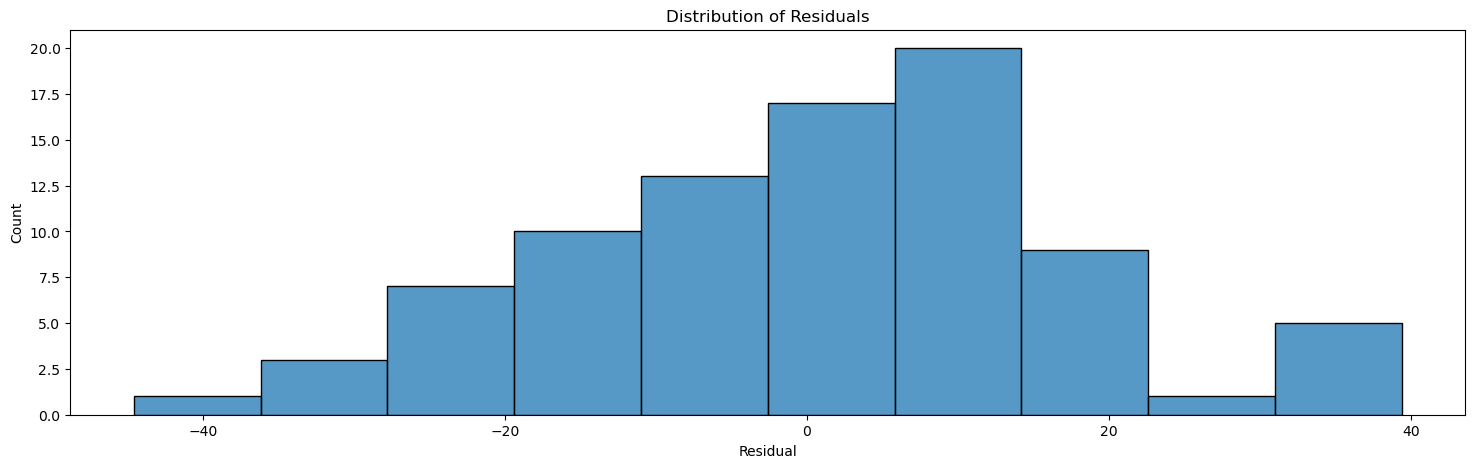

In [51]:
xbg_preds = best_xgb_regressor.predict(X_test)
actuals = y_test
resids = xbg_preds - actuals
plt.figure(figsize=(18,5))
sns.histplot(resids);
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Count')

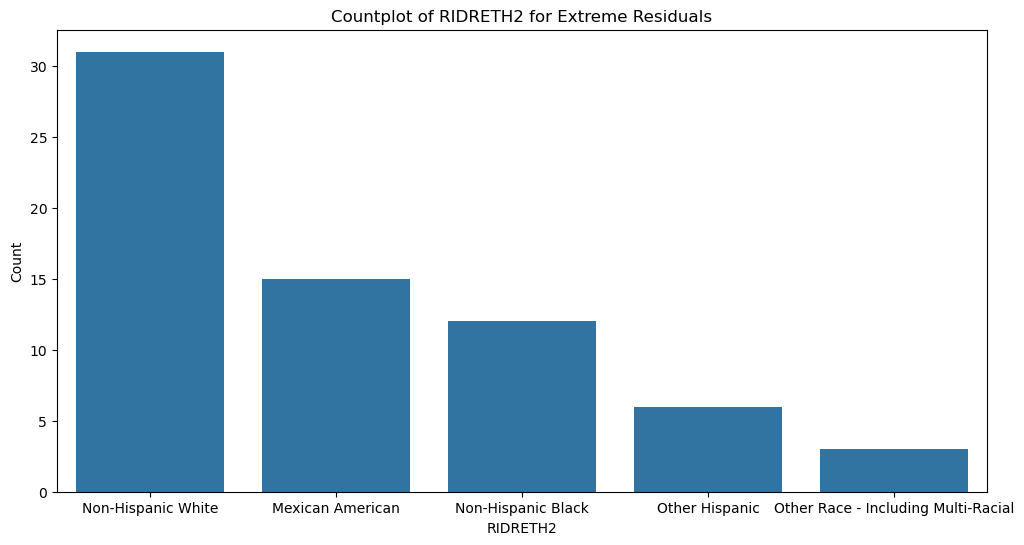

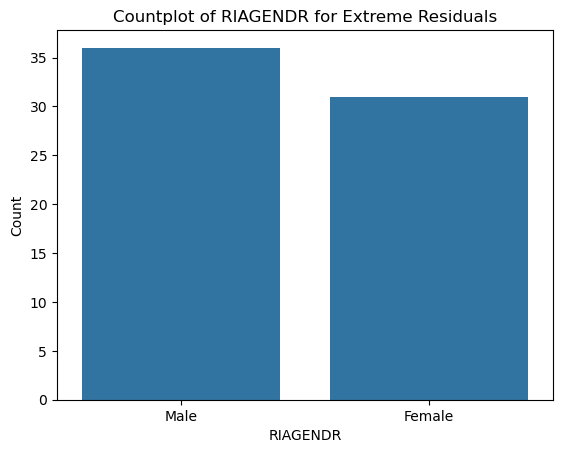

In [52]:
# turn y_test into Pandas series so can index
y_test_series = pd.Series(y_test, index=df.index[:len(y_test)])

# Convert residuals to a pandas Series with the same index
resids_series = pd.Series(resids, index=y_test_series.index)

# Filter the indices where residuals are less than -5 or greater than 5 
filtered_indices = resids_series[(resids_series < -5) | (resids_series > 5)].index
df['RIDRETH2_decoded'] = label_encoders['RIDRETH2'].inverse_transform(df['RIDRETH2'])
df['RIAGENDR_decoded'] = label_encoders['RIAGENDR'].inverse_transform(df['RIAGENDR'])
plt.figure(figsize=(12, 6))
sns.countplot(data=df.loc[filtered_indices], x='RIDRETH2_decoded')
plt.title('Countplot of RIDRETH2 for Extreme Residuals')
plt.xlabel('RIDRETH2')
plt.ylabel('Count')
plt.show()

sns.countplot(data=df.loc[filtered_indices], x='RIAGENDR_decoded')
plt.title('Countplot of RIAGENDR for Extreme Residuals')
plt.xlabel('RIAGENDR')
plt.ylabel('Count')
plt.show()


/var/folders/6p/6161x96942x8rv20mn8nby2r0000gn/T/ipykernel_39214/3522221576.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = varimps.Factor, y=varimps['Relative Importance'], palette='Paired');


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

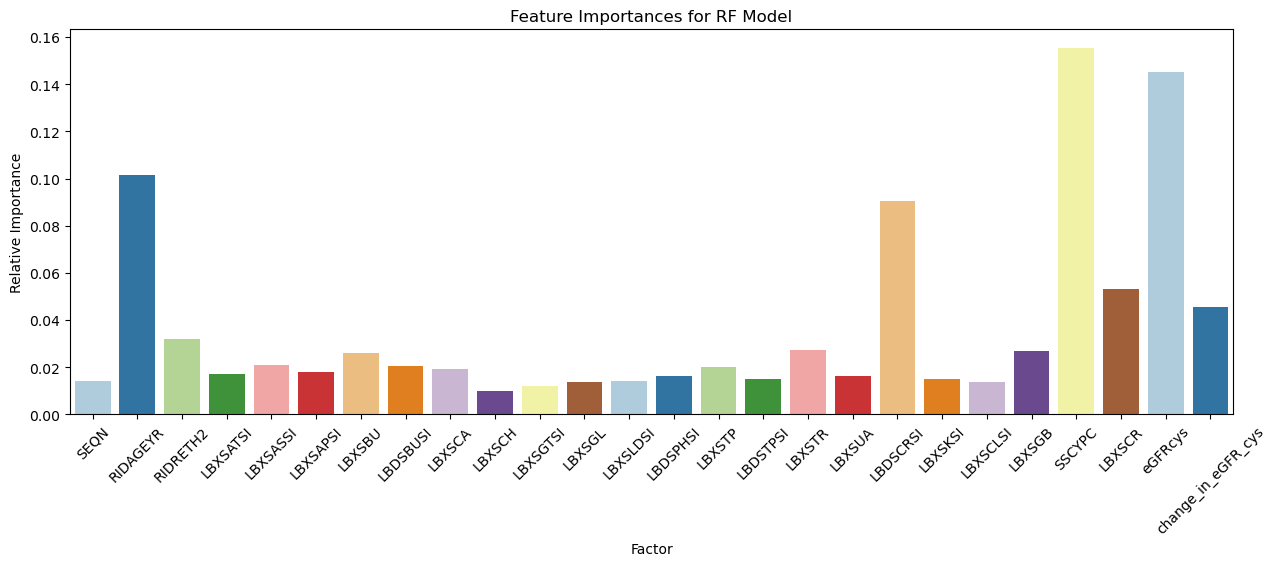

In [56]:
varimp = []
for name, score in zip(X_labeled.columns, best_xgb_regressor.feature_importances_):
    if score >= 0.01:
        varimp.append((name, score))

varimpdf = pd.DataFrame(varimp)

d = {'Factor': varimpdf[0], 'Relative Importance': varimpdf[1]}
varimps = pd.DataFrame(data=d)

plt.figure(figsize=(15,5))
plt.title("Feature Importances for RF Model")
sns.barplot(x = varimps.Factor, y=varimps['Relative Importance'], palette='Paired');
plt.xticks(rotation=45)

In [54]:
varimps.sort_values(by = 'Relative Importance', ascending=False)


,Factor,Relative Importance
22,SSCYPC,0.155470
24,eGFRcys,0.145149
1,RIDAGEYR,0.101632
18,LBDSCRSI,0.090552
23,LBXSCR,0.053132
25,change_in_eGFR_cys,0.045494
2,RIDRETH2,0.031816
16,LBXSTR,0.027142
21,LBXSGB,0.026820
6,LBXSBU,0.025994


Text(0, 0.5, 'Actual Values')

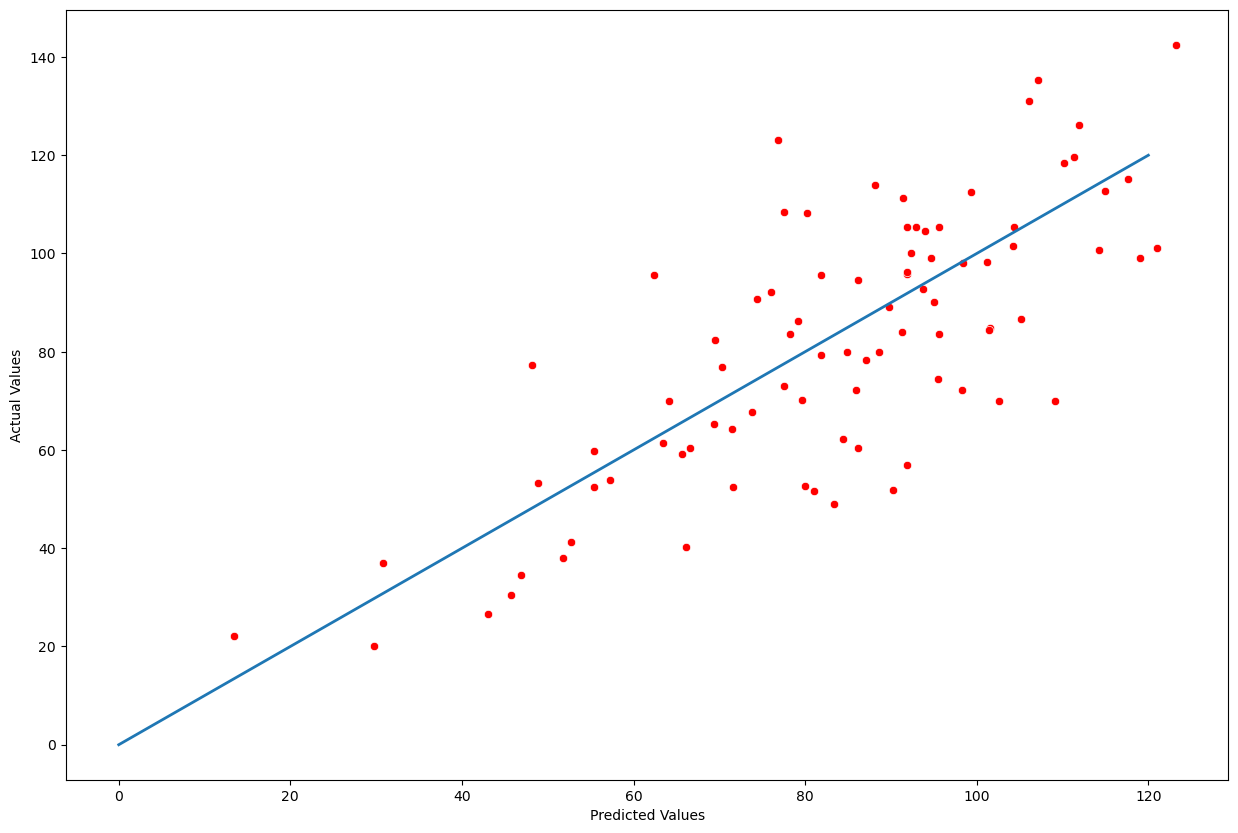

In [49]:
plt.figure(figsize=(15, 10));
sns.scatterplot(x=xgb_regressor.predict(X_test), y=y_test, color="red");
plt.plot([0, 120], [0, 120], linewidth=2);
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")